In [7]:
import pandas as pd
import pandana as pdna
import time
import os
import json
import urllib
from shapely.geometry import Point, shape

import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network

%matplotlib inline

In [8]:
# Pandana currently uses depreciated parameters in matplotlib, this hides the warning until its fixed
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [9]:
city='Detroit'

Get the geographical bounds for the city and the feed for the city's GTFS data

In [10]:
url = 'https://github.com/CityScope/CS_Mobility_Service/raw/master/scripts/cities/'+city+'/clean/model_area.geojson'
response = urllib.request.urlopen(url)
zones = json.loads(response.read())

In [11]:
area=[shape(f['geometry']) for f in zones['features']]
bounds=[shp.bounds for shp in area]
bbox=(min([b[0] for b in bounds]), #W
               min([b[1] for b in bounds]), #S
               max([b[2] for b in bounds]), #E
               max([b[3] for b in bounds])) #N

In [12]:
bbox

(-83.551907, 42.0314796546585, -82.870347, 42.451235)

In [7]:
if city=='Hamburg':
    feeds.add_feed(add_dict={'Hamburg': 'http://daten.transparenz.hamburg.de/Dataport.HmbTG.ZS.Webservice.GetRessource100/GetRessource100.svc/32aedec8-c69f-4053-a5e8-9b1267eb25de/Upload__HVV_Rohdaten_GTFS_Fpl_20190207.zip'})
#     bbox = (9.972308, 53.513722,  10.033365, 53.558708)
elif city=='Boston':
    feeds.add_feed(add_dict={'Massachusetts Bay Transportation Authority': 'https://cdn.mbta.com/MBTA_GTFS.zip'})
#     bbox = (-71.135117,42.318822,  -71.010919, 42.385857)
elif city=='Detroit':
    feeds.add_feed(add_dict={'DDOT': 'https://data.detroitmi.gov/download/y62d-bvsz/application%2Fzip'})
    feeds.add_feed(add_dict={'People Mover': 'https://data.detroitmi.gov/api/views/4bkd-9u3w/files/c32fecf1-d8cc-4e53-8fc1-a021ccf4d0a9?filename=dtc-gtfs.zip'})
#     bbox = (-71.135117,42.318822,  -71.010919, 42.385857)

Added 1 feeds to gtfs_feeds: {'Hamburg': 'http://daten.transparenz.hamburg.de/Dataport.HmbTG.ZS.Webservice.GetRessource100/GetRessource100.svc/32aedec8-c69f-4053-a5e8-9b1267eb25de/Upload__HVV_Rohdaten_GTFS_Fpl_20190207.zip'}


Download GFTS data

In [8]:
os.chdir('./'+city)

In [9]:
gtfsfeeds.download()

1 GTFS feeds will be downloaded here: data/gtfsfeed_zips
Hamburg GTFS feed downloaded successfully. Took 53.02 seconds for 29,303,447.0KB
GTFS feed download completed. Took 53.02 seconds
Hamburg.zip successfully extracted to: data/gtfsfeed_text/Hamburg
GTFS feed zipfile extraction completed. Took 2.41 seconds for 1 files


Load GTFS data into an UrbanAccess transit data object

In [10]:
validation = True
verbose = True
remove_stops_outsidebbox = True
append_definitions = True

loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=None,
                                           validation=validation,
                                           verbose=verbose,
                                           bbox=bbox,
                                           remove_stops_outsidebbox=remove_stops_outsidebbox,
                                           append_definitions=append_definitions)

GTFS text file header whitespace check completed. Took 5.05 seconds
--------------------------------
Processing GTFS feed: Hamburg
agency.txt agency_name column has more than one agency name listed. Unique agency id was assigned using the agency id and associated agency name.
Unique agency id operation complete. Took 25.26 seconds
Unique GTFS feed id operation complete. Took 0.01 seconds
Records: {}
              stop_id  stop_code                                stop_name  \
491      000000025900        NaN           Friedrichsruh, Bismarck-Museum   
511      000000026014        NaN                        Escheburg, Bistal   
554      000000027001        NaN                                    Worth   
555      000000027002        NaN                       Hamwarde, Forstweg   
556      000000027003        NaN                     Hamwarde, Dorfstraße   
557      000000027004        NaN                     Hamwarde, Jetmoorweg   
558      000000027005        NaN                  Hamwarde

Appended route type to stops
Appended route type to stop_times
--------------------------------
Added descriptive definitions to stops, routes, stop_times, and trips tables
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 5.62 seconds
1 GTFS feed file(s) successfully read as dataframes:
     Hamburg
     Took 43.17 seconds


Quickly view the transit stop locations

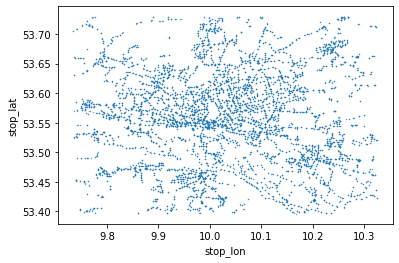

In [11]:
loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)

Create a travel time weighted graph for weekday `monday` service between 7 am and 10 am (`['07:00:00', '10:00:00']`) to represent travel times during the AM Peak period

In [12]:
ua.gtfs.network.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day='monday',
                                   timerange=['07:00:00', '10:00:00'],
                                   calendar_dates_lookup=None)

Using calendar to extract service_ids to select trips.
235 service_ids were extracted from calendar
36,268 trip(s) 48.76 percent of 74,378 total trip records were found in calendar for GTFS feed(s): ['hamburg']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
36,268 of 74,378 total trips were extracted representing calendar day: monday. Took 0.15 seconds
There are no departure time records missing from trips following monday schedule. There are no records to interpolate.
Difference between stop times has been successfully calculated. Took 12.67 seconds
Stop times from 07:00:00 to 10:00:00 successfully sele

Create a reference to the global network object called `urbanaccess_net`

In [13]:
urbanaccess_net = ua.network.ua_network

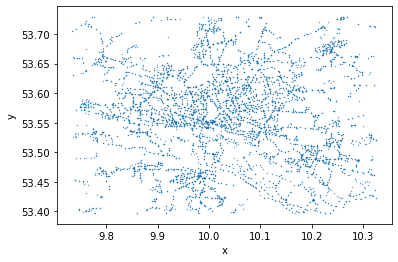

In [14]:
urbanaccess_net.transit_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

# Download OSM data

In [ ]:
nodes, edges = ua.osm.load.ua_network_from_bbox(bbox=bbox,
                                                remove_lcn=True)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](53.39638100,9.73441374,53.72943554,10.32527111);>;);out;'}"
Downloaded 91,691.0KB from www.overpass-api.de in 31.56 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 34.00 seconds
Returning OSM data with 597,797 nodes and 157,169 ways...
Edge node pairs completed. Took 425.27 seconds
Returning processed graph with 194,559 nodes and 537,762 edges...
Completed OSM data download and Pandana node and edge table creation in 479.84 seconds
checking for low connectivity nodes...


Create a travel time weighted graph from the pedestrian network - assume a pedestrian travels on average at 3 mph.
The resulting weighted network will be added to your UrbanAccess network object inside `osm_nodes` and `osm_edges`

In [ ]:
remove_link_types=[
 'bridleway',
 'services',
 'steps',
 'footway',
 'cycleway',
 'service',
 'traffic_island',
 'unclassified',
 'track',
 'path'
]

In [ ]:
edges=edges.loc[~edges['highway'].isin(remove_link_types)]
all_nodes_included=set(list(edges['from'].values)+list(edges['to'].values))
nodes=nodes.loc[nodes['id'].isin(all_nodes_included)]

In [ ]:
nodes.to_csv('./data/osm_ped_network_nodes.csv', index=False)
edges.to_csv('./data/osm_ped_network_edges.csv', index=False)

In [ ]:
ua.osm.network.create_osm_net(osm_edges=edges,
                              osm_nodes=nodes,
                              travel_speed_mph=3)

In [ ]:
urbanaccess_net.osm_nodes.head()

In [ ]:
urbanaccess_net.osm_edges.head()

In [ ]:
urbanaccess_net.osm_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

Add average transit headways

In [ ]:
ua.gtfs.headways.headways(gtfsfeeds_df=loaded_feeds,
                          headway_timerange=['07:00:00','10:00:00'])

In [ ]:
loaded_feeds.headways.head()

In [ ]:
# Not using the headways
ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=False,
                             urbanaccess_gtfsfeeds_df=loaded_feeds,
                             headway_statistic='mean')

# Create an integrated transit and pedestrian network

In [ ]:
urbanaccess_net.net_nodes.head()

In [ ]:
urbanaccess_net.net_edges.head()

In [ ]:
urbanaccess_net.net_edges[urbanaccess_net.net_edges['net_type'] == 'transit'].head()

Plot the combined network

In [ ]:
edgecolor_weight = ua.plot.col_colors(df=urbanaccess_net.net_edges, col='weight', cmap='gist_heat_r', num_bins=5)

In [ ]:
edgecolor_type=list(urbanaccess_net.net_edges.apply(lambda row: (1,0,0,1) if row['net_type']=='transit' else (127/255,201/255,127/255, 1), axis=1))

Plot by link type

In [ ]:
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 bbox=bbox,
                 fig_height=30, margin=0.02,
                 edge_color=edgecolor_type, edge_linewidth=2, edge_alpha=0.8,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

In [ ]:
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 bbox=bbox,
                 fig_height=30, margin=0.02,
                 edge_color=edgecolor_weight, edge_linewidth=2, edge_alpha=0.8,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

Save the combined network as csv

In [ ]:
urbanaccess_net.net_nodes.to_csv('./data/comb_network_nodes.csv')
urbanaccess_net.net_edges.to_csv('./data/comb_network_edges.csv')

# Using an UrbanAccess network with Pandana

- set any Pandana `two_way` parameters to `False` (they are `True` by default) to indicate that the network is a one way network.
- `node ids` and `from` and `to` columns in your network must be integer type and not string. 
- edge weights represent travel time in minutes.

## Initialize the Pandana network

Let's initialize our Pandana network object using our transit and pedestrian network we created. Note: the `from_int` and `to_int` as well as the `twoway=False` denoting this is a explicit one way network.

In [ ]:
s_time = time.time()
transit_ped_net = pdna.Network(urbanaccess_net.net_nodes["x"],
                               urbanaccess_net.net_nodes["y"],
                               urbanaccess_net.net_edges["from_int"],
                               urbanaccess_net.net_edges["to_int"],
                               urbanaccess_net.net_edges[["weight"]], 
                               twoway=False)
print('Took {:,.2f} seconds'.format(time.time() - s_time))

In [36]:
s_time = time.time()
transit_ped_net.precompute(20)
print('Took {:,.2f} seconds'.format(time.time() - s_time))

Took 156.32 seconds


Get amenity data

In [37]:
import urllib.request
import json
# =============================================================================
# Constants
# =============================================================================
OSM_URL_ROOT='https://lz4.overpass-api.de/api/interpreter?data=[out:json][bbox];node[~"^(amenity|leisure|shop)$"~"."];out;&bbox='

tags={
      'food': ['amenity_restaurant', 'amenity_cafe' 'amenity_fast_food', 'amenity_pub'],
      'nightlife': ['amenity_bar' , 'amenity_pub' , 'amenity_nightclub', 'amenity_biergarten'],  #(according to OSM, pubs may provide food, bars dont)
      'groceries': ['shop_convenience', 'shop_grocer', 'shop_greengrocer', 'shop_food', 'shop_supermarket'], 
      'education': ['amenity_school', 'amenity_university', 'amenity_college']
      }
# =============================================================================
# get all amenities in within bounding box of study area
# =============================================================================
bounds_all=lng_min, lat_min, lng_max, lat_max = bbox
# To get all amenity data
str_bounds=str(bounds_all[0])+','+str(bounds_all[1])+','+str(bounds_all[2])+','+str(bounds_all[3])
osm_url_bbox=OSM_URL_ROOT+str_bounds
with urllib.request.urlopen(osm_url_bbox) as url:
    data=json.loads(url.read().decode())

In [38]:
# =============================================================================
# Create a list including only the amenity types we're interested in
# include each possible tag as a property
# =============================================================================
amenities=[]
for a in range(len(data['elements'])):
    include=0
    for t in tags:
        data['elements'][a][t]=0
        for recordTag in list(data['elements'][a]['tags'].items()):
            if recordTag[0] +'_'+recordTag[1] in tags[t]:
                data['elements'][a][t]=1
                include=1
    if include==1:
        new_amenity={t: data['elements'][a][t] for t in tags}
        new_amenity['x']=data['elements'][a]['lon']
        new_amenity['y']=data['elements'][a]['lat']
        amenities.append(new_amenity)

In [39]:
amenities_df=pd.DataFrame(amenities)

In [40]:
amenities_df.head()

,education,food,groceries,nightlife,x,y
0,0,1,0,0,10.277065,53.520752
1,0,1,0,0,10.116440,53.608073
2,0,1,0,0,10.043627,53.578873
3,0,1,0,1,9.866034,53.533848
4,0,1,0,0,9.885703,53.520219


In [41]:
for t in tags:
    transit_ped_net.set_pois(t, 20, 10, amenities_df.loc[amenities_df[t]==1, 'x'], amenities_df.loc[amenities_df[t]==1, 'y'])

In [42]:
dist_to_second={}
for t in tags:
    dist_to_second[t]=transit_ped_net.nearest_pois(20, t, num_pois=2).loc[:,2]

In [43]:
import matplotlib.pyplot as plt

In [44]:
color_scale=['#a50026',
'#d73027',
'#f46d43',
'#fdae61',
'#fee08b',
'#ffffbf',
'#d9ef8b',
'#a6d96a',
'#66bd63',
'#1a9850',
'#006837']

scale, colors={},{}
for t in tags:
    scale[t]=[1-(dist_to_second[t].iloc[i]/15) for i in range(len(dist_to_second[t]))]
for s in scale:
    colors[s]=[color_scale[int(scale[s][i]*10)] for i in range(len(scale[s]))]

# Amenity Accessibility
## Food

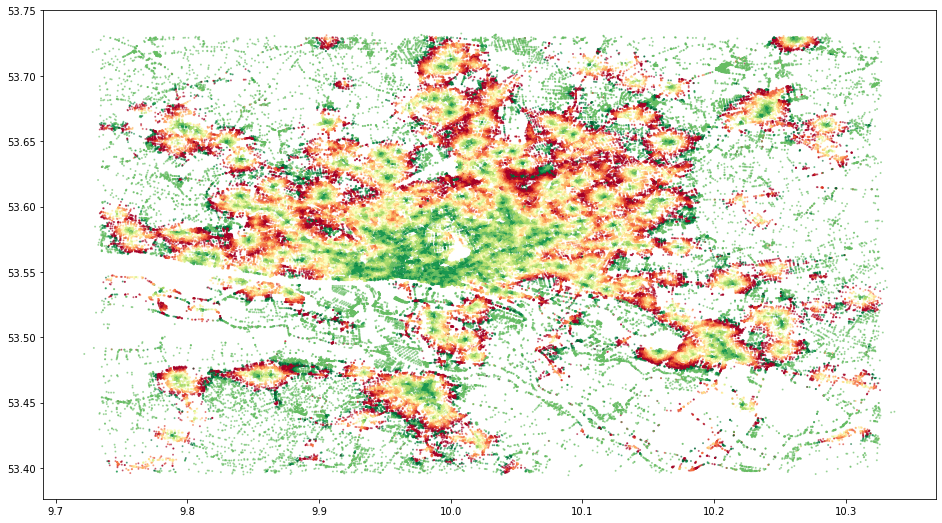

In [45]:
fig=plt.figure(figsize=(16,9))
plt.scatter(transit_ped_net.nodes_df["x"],
         transit_ped_net.nodes_df["y"],
        color=colors['food'], alpha=0.5, s=1)

## Groceries

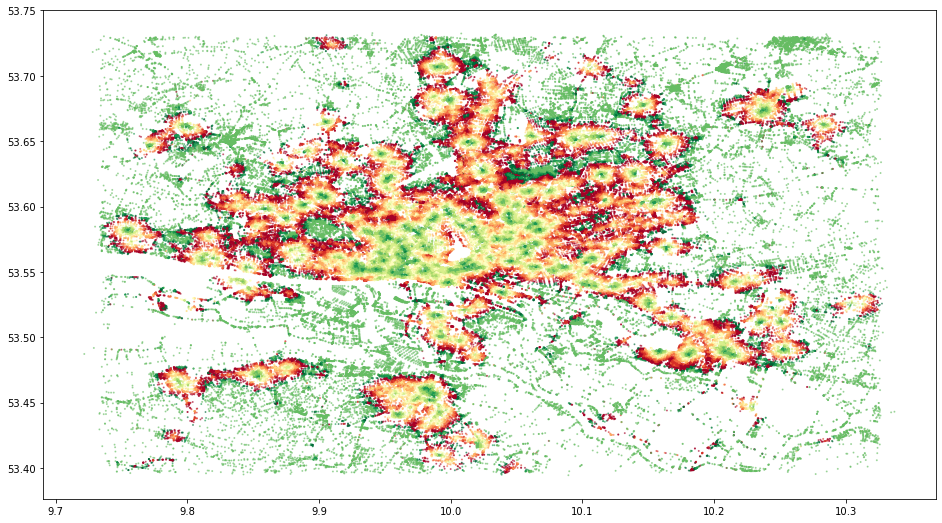

In [46]:
fig=plt.figure(figsize=(16,9))
plt.scatter(transit_ped_net.nodes_df["x"],
         transit_ped_net.nodes_df["y"],
        color=colors['groceries'], alpha=0.5, s=1)

# Nightlife

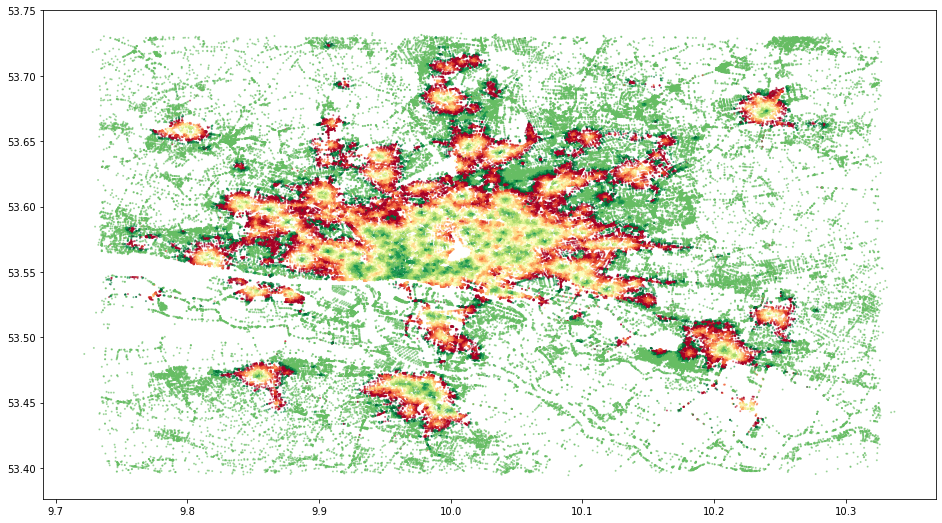

In [47]:
fig=plt.figure(figsize=(16,9))
plt.scatter(transit_ped_net.nodes_df["x"],
         transit_ped_net.nodes_df["y"],
        color=colors['nightlife'], alpha=0.5, s=1)

## Education

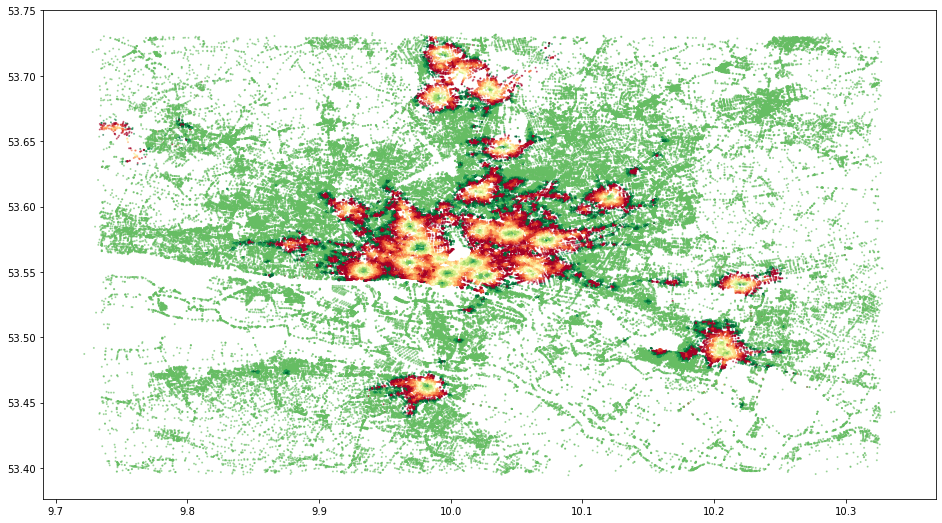

In [48]:
fig=plt.figure(figsize=(16,9))
plt.scatter(transit_ped_net.nodes_df["x"],
         transit_ped_net.nodes_df["y"],
        color=colors['education'], alpha=0.5, s=1)

Save the pandana network (just the network, no associated data)

In [49]:
transit_ped_net.save_hdf5('./data/comb_network.hdf5')

Save the amenity dataframes

In [50]:
amenities_df.to_csv('./data/amenities.csv', index=False)